In [6]:
#!pip install libs_qrem
#!pip install qiskit-ignis   


In [13]:
from qiskit import IBMQ
IBMQ.save_account('872395c64aae629a782c0f29e240279b70d8831a8a57be2271e6bc43a62dc9760e9029602bd94b411651319af154544a5fa015225362d0574d77d193720673b2', overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import standard_errors, ReadoutError

def getNoiseModel_no_readouterror(self):
		# Depolarizing quantum errors
		oneQubitError = standard_errors.depolarizing_error(self.oneQubitErrorProb, 1)
		twoQubitError = standard_errors.depolarizing_error(self.twoQubitErrorProb, 2)
		qubitReadoutError = ReadoutError([self.zeroReadoutErrorProb, self.oneReadoutErrorProb])

		# Add errors to noise model
		noiseModel = NoiseModel()
		noiseModel.add_all_qubit_quantum_error(oneQubitError, self.basisGateSetString)
		noiseModel.add_all_qubit_quantum_error(twoQubitError, ['cx'])
		

		return noiseModel

Target fault: { gateType: CX, qubits: 0-1 }
Length: 10	Repetition: 18	Cost: 180
Chi-Value boundary: 11.352866472869493
Effect Size: 2.1369908626855216
Overkill: 0.0141	Test Escape: 0.0158

no_readouterror
[{'00': 200000}, {'11': 200000}]
noisy_hist
[{'00': 194149, '10': 2920, '01': 2885, '11': 46}, {'11': 194085, '10': 2949, '01': 2928, '00': 38}]
calibration matrices
[array([[0.985345, 0.014935],
       [0.014655, 0.985065]]), array([[0.98517, 0.01483],
       [0.01483, 0.98517]])]
Readout fidelity of Q0: 0.985205
Q0 Calibration Matrix


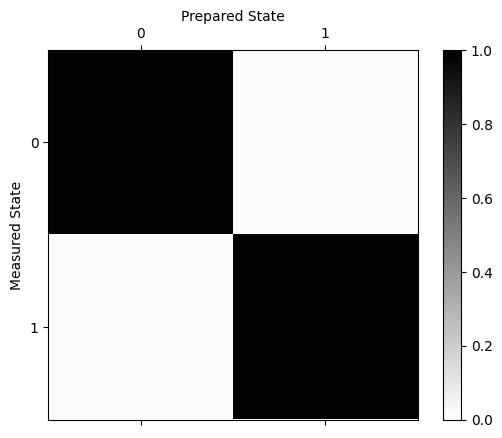

Readout fidelity of Q1: 0.985170
Q1 Calibration Matrix


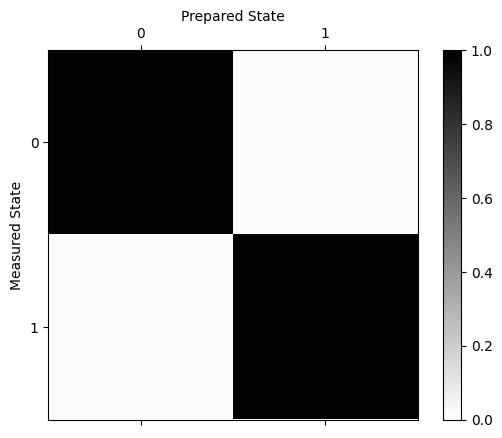

mitigated_hist
[{'00': 200000.0}, {'01': 4.458386547229257, '10': 4.458386547229257, '11': 199991.08322690552}]
no_readouterror
{'00': 31131, '10': 41612, '11': 100239, '01': 27018}


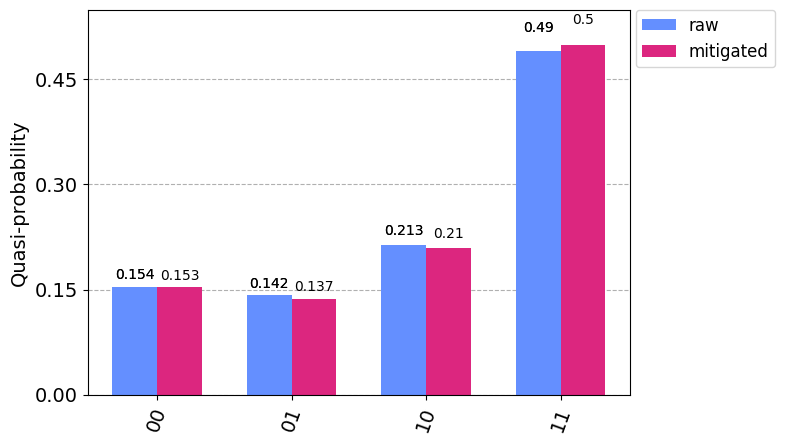

raw_counts
{'11': 98045, '10': 42656, '00': 30823, '01': 28476}
mitigated_counts
{'00': 30683.01297252682, '01': 27371.895616215268, '10': 41958.44785330969, '11': 99986.64355794819}


In [15]:
from qiskit import QuantumRegister, Aer, execute
from qiskit.ignis.mitigation.measurement import tensored_meas_cal
import numpy as np
import qiskit.circuit.library as qGate
from qiskit.extensions import UnitaryGate
from qiskit.ignis.mitigation.measurement import TensoredMeasFitter
from qatg import QATG
from qatg import QATGFault
from libs_qrem import LeastNormFilter
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import standard_errors, ReadoutError




class myCNOTFault(QATGFault):
	def __init__(self):
		super(myCNOTFault, self).__init__(qGate.CXGate, [0, 1], f"gateType: CX, qubits: 0-1")
	def createOriginalGate(self):
		return qGate.CXGate()
	def createFaultyGate(self, faultfreeGate):
		if not isinstance(faultfreeGate, qGate.CXGate):
			raise TypeError("what is this faultfreeGate")
		matrix = qGate.CXGate().to_matrix()
		UF = qGate.UGate(0.05*np.pi, 0.05*np.pi, 0.05*np.pi)
		matrix = np.matmul(np.kron(np.eye(2), UF), matrix)
		matrix = np.matmul(matrix, np.kron(UF, np.eye(2)))
		return UnitaryGate(matrix)

generator = QATG(circuitSize = 2, basisGateSet = [qGate.UGate], circuitInitializedStates = {2: [1, 0, 0, 0]}, minRequiredEffectSize = 2)
configurationList = generator.createTestConfiguration([myCNOTFault()])

def qatg_QREM(configuration):
    
    #first run the calibration circuit
    n = configuration.circuitSize
    qr = configuration.quantumRegister 
    mit_pattern = []
    for i in range(n):
        singlebit = [i]
        mit_pattern.append(singlebit)
    
    meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
    backend = Aer.get_backend('aer_simulator')
    
    no_readouterror_job = execute(meas_calibs, backend=backend, shots=200000,noise_model=getNoiseModel_no_readouterror(configuration))
    no_readouterror_cal_results = no_readouterror_job .result()
    print("no_readouterror")
    print(no_readouterror_cal_results.get_counts())
    
    noise_job = execute(meas_calibs, backend=backend, shots=200000, noise_model=configuration.getNoiseModel())
    noise_cal_results = noise_job.result()
    noisy_hist = noise_job.result().get_counts()
    print("noisy_hist")
    print(noisy_hist)
    
    meas_fitter = TensoredMeasFitter(noise_cal_results, mit_pattern=mit_pattern)
    print("calibration matrices")
    print(meas_fitter.cal_matrices)
    
    for i in range(n):
        print('Readout fidelity of Q'+str(i)+': %f'%meas_fitter.readout_fidelity(i))
        print('Q'+str(i)+' Calibration Matrix')
        meas_fitter.plot_calibration(i)
    
    
    
    meas_filter = LeastNormFilter(n, meas_fitter.cal_matrices)
    
    
    mitigated_hist = meas_filter.apply(noisy_hist)
    print("mitigated_hist")
    print(mitigated_hist)
    #count = mitigated_hist.get_counts()
    
    #display(plot_histogram([noisy_hist, count], legend=['raw', 'mitigated']))
    
    #run the fault_free circuit
    faultfree_noreadouterror = execute(configuration.faultfreeQCKT, backend=backend, shots=200000,noise_model=getNoiseModel_no_readouterror(configuration))
    faultfree_noreadouterror_results = faultfree_noreadouterror.result()
    # Results without mitigation
    
    no_readouterror = faultfree_noreadouterror_results.get_counts()
    print("no_readouterror")
    print(no_readouterror)
    
    
    
    faultfree_noisy_job = execute(configuration.faultfreeQCKT, backend=backend, shots=200000, noise_model=configuration.getNoiseModel())
    faultfree_noisy_results = faultfree_noisy_job.result()
    
    # Results without mitigation
    faultfree_raw_counts = faultfree_noisy_results.get_counts()

    # Get the filter object
    #meas_filter = meas_fitter.filter
    #print(meas_filter.cal_matrices)
    # Results with mitigation
    mitigated_results = meas_filter.apply(faultfree_noisy_results)
    mitigated_counts = mitigated_results.get_counts()
    display(plot_histogram([faultfree_raw_counts, mitigated_counts], legend=['raw', 'mitigated']))
    print("raw_counts")
    print(faultfree_raw_counts)
    print("mitigated_counts")
    print(mitigated_counts)
    





for configuration in configurationList:
    print(configuration)
    configuration.circuit.draw('mpl')
    qatg_QREM(configuration)
